<a href="https://colab.research.google.com/github/0011Ashwin/Google-Colab-Work/blob/main/Lang_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install langgraph langsmith

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 21.2 MB/s eta 0:00:00


In [5]:
# library
!pip install langchain langchain_groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade langgraph


In [1]:
# user
from google.colab import userdata
groq_api_key = userdata.get('groq_api_key').strip()

# %%
lang_smith_api_key = userdata.get('LANG_SMITH_KEY')
# %%
import os
os.environ['GROQ_API_KEY'] = groq_api_key
os.environ['LANGCHAIN_TRACING_V2'] = 'true'


In [2]:
lang_smith_api_key = userdata.get('LANG_SMITH_KEY')

In [3]:
import os
os.environ['GROQ_API_KEY'] = groq_api_key
os.environ['LANGCHAIN_TRACING_V2'] = 'true'

In [6]:
from langchain_groq import ChatGroq

In [7]:
# creating LLM(Large language model)
LLM = ChatGroq(groq_api_key = groq_api_key , model_name = 'llama3-70b-8192')
LLM

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d1bd6fb6a50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d1bd6bf5350>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Start building Chatbot using LangGraph



In [10]:
from typing import Annotated
# from typing extension importing teype-dict
from typing_extensions import TypedDict
# In graph we have start-graph , start node and end node
from langgraph.graph import StateGraph , START , END
# user query node transfer node model
from langgraph.graph.message import add_messages

In [11]:
class State(TypedDict):
  # Message have the type "list" The add_message function
    # in the annotation define how this state key should be updated
    # (in this case, it append message to the list , rather than overwriting them)
  message : Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [12]:
graph_builder

In [13]:
# creating node
def chatbot(state:State):
  return {"message":LLM.invoke(state['message'])}

In [14]:
# Adding node in graph so we can query it for user
graph_builder.add_node("chatbot", chatbot)

In [15]:
graph_builder

In [16]:
# connecting start node and last node with chatbot
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


In [17]:
graph = graph_builder.compile()

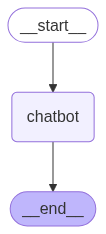

In [18]:
# showing node
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
while True:
  user_input=input("User: ")
  if user_input.lower() in ["quit","q"]:
    print("Good Boss")
    break
  # The graph expects the input to be a state dictionary.
  # The 'message' key in the State TypedDict is annotated with add_messages,
  # which appends to a list. Therefore, the initial input for 'message'
  # should be a list containing the first message.
  for event in graph.stream({'message':[("user",user_input)]}):
    # The streamed event is a dictionary where the key is the node name
    # and the value is a dictionary of state updates from that node.
    # We are interested in the output of the 'chatbot' node.
    if "chatbot" in event:
        # Get the state updates from the chatbot node
        chatbot_output = event["chatbot"]
        # The chatbot node returns {"message": LLM.invoke(...)}
        # With add_messages, this message is processed and potentially appended to the list.
        # When streaming, the event for the chatbot node seems to contain
        # the newly generated message directly in value['message'] after add_messages processing.
        if 'message' in chatbot_output:
            messages = chatbot_output['message']
            # Check if the message is an AIMessage object, which is the AI's response.
            # If add_messages were appending to a list directly in the streamed output,
            # we would look for the last item in the list.
            # Given the error and the likely structure of the streamed event with add_messages,
            # we directly check if the value associated with 'message' is the AI response.
            if isinstance(messages, list) and messages and messages[-1].type == 'ai':
                 print("Friday:", messages[-1].content)
            elif messages and messages.type == 'ai':
                # This handles the case where the message value itself is the AIMessage object
                print("Friday:", messages.content)

User: hello
Friday: Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?


User: What is data science


Friday: Data science is a multidisciplinary field that extracts insights and knowledge from structured and unstructured data using various tools, techniques, and methods. It involves using data to identify trends, patterns, and correlations, and to make informed decisions.

Data science is a combination of several fields, including:

1. **Statistics**: The study of the collection, analysis, interpretation, presentation, and organization of data.
2. **Computer Science**: The study of the theory, design, development, and testing of computer systems and algorithms.
3. **Machine Learning**: A subfield of artificial intelligence that involves the use of data to train models that can make predictions or take actions.
5. **Domain Expertise**: Understanding of the industry, business, or field in which the data is being applied.

The process of data science typically involves the following steps:

1. **Problem Formulation**: Identifying a problem or opportunity that can be addressed using data.

User: thank you friday
Friday: You're welcome! Fridays are always a great day to wrap up the week and look forward to some relaxation and fun!
